# Evaluating a predictive model

In this notebook, we intend to:

- introduce in an intuitive manner a linear model on a regression task
- introduce the user API of scikit-learn
- introduce the concept of training and testing error
- introduce the concept of cross-validation
- compare a model with some other baseline models

# Gentle introduction to linear regression

We will start by introducing the concept of linear regression. First, we will not use any advanced tool as scikit-learn and instead made use of only NumPy. First, let's load the dataset that we will use for this exercise.

In [45]:
import pandas as pd

data = pd.read_csv("../datasets/penguins_regression.csv")
data.head()

,Flipper Length (mm),Body Mass (g)
0,181.0,3750.0
1,186.0,3800.0
2,195.0,3250.0
3,193.0,3450.0
4,190.0,3650.0


We will use a dataset containing records of some penguins flipper length and body mass. The first task that we want to accomplish is to learn a predictive model where we would like to estimate the body mass of a penguins given its flipper length. Since the target is continuous, this problem is a regression problem.

Let's first have a look at the relationship between these measurements

In [46]:
import seaborn as sns
sns.set_context("poster")

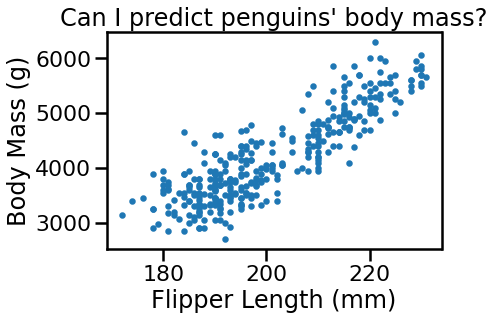

In [47]:
ax = data.plot.scatter(x=data.columns[0], y=data.columns[1])
_ = ax.set_title("Can I predict penguins' body mass?")

We see could see that we have a linear trend between the flipper length and the body mass: longer is the penguin's flipper, heavier is the penguin. The first predictive model that we would like to have will model the relationship between these two variables as a linear relationship.

Thus, in this example:

- the flipper length is a feature. Here, we will only use a single feature. In practise, we will have many features when trying to create a predictive model.
- the body mass is the variable that we would like to predict, thus it is the target.

A pair of measurement (flipper length, body mass) is called a sample. We learn a predictive model from available pair of such features/target. At prediction time, we will only have the features available and the goal is to predict the potential target. To evaluate a predictive model, we can then use some of the features and compare the predictions given by the model with the true target.

For the rest of this lecture, we will denote the variable `X` as the matrix of shape `(n_samples, n_features)` and the target will be denoted by the variable `y` as a vector of shape `(n_samples,)`.

In [48]:
X, y = data[["Flipper Length (mm)"]], data[["Body Mass (g)"]]

To start, we would like to model the relationship between `X` and `y` by a linear relationship. Thus, we can formalize it as:

$$
y = X \beta
$$

where $\beta$ are the coefficients of our linear model. We could expand this equation for all available features as:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n
$$

Here, we only have a single feature, $\beta_1$, that is the flipper length.

Finding a linear model is equivalent to find the "best possible" $\beta$. What is the best $\beta$? The best $\beta$ would be the $\beta$ that once used with $X$ will predict $\hat{y}$ such that the $\hat{y}$ (i.e. the predicted target) is as closed as possible of $y$ (i.e. the true target). Thus, we would like to minimize an error. We can find the $\beta$ from the equation above:

$$
X^T y = X^T X \beta
$$

and thus

$$
\beta = (X^T X)^{-1} X^T y
$$

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Using NumPy, find $\beta$ ($\beta_0$ and $\beta_1$) using the normal equation above.</li>
        <li>Once you found these $\beta$ compute the predictions given the matrix $X$.</li>
        <li>Plot the true data ($X$) and target ($y$) as previously done. Plot the predicted target given by the model ($\hat{y}$).</li>
    </ul>
</div>

In [49]:
X["Intercept"] = 1

In [50]:
X.head()

,Flipper Length (mm),Intercept
0,181.0,1
1,186.0,1
2,195.0,1
3,193.0,1
4,190.0,1


In [51]:
import numpy as np

coef = np.linalg.inv(X.T @ X) @ X.T @ y
coef

,Body Mass (g)
0,49.685566
1,-5780.831358


In [52]:
y_pred = np.dot(X, coef)
y_pred[:5]

array([[3212.25616143],
       [3460.68399346],
       [3907.85409111],
       [3808.4829583 ],
       [3659.42625908]])

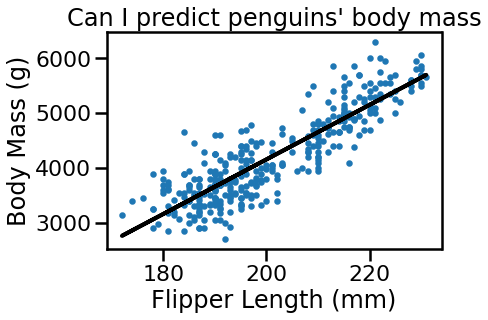

In [53]:
ax = data.plot.scatter(x=data.columns[0], y=data.columns[1])
ax.plot(X["Flipper Length (mm)"], y_pred, color="black", linewidth=4)
_ = ax.set_title("Can I predict penguins' body mass")

## Introduction to scikit-learn API

Scikit-learn is using Python classes to give some state to Python object. In machine-lerning context, it is handy to have object that will "learn" some internal states. Once these states are learnt, the object could be used to make the prediction. In scikit-learn, we thus have Python class to create instance that will have:

- a `fit` method to learn the internal states
- a `predict` method to output some predicted values given some input data

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Given the linear model used in the previous section. Create a Python class with:
    <ul>
        <li>a <tt>fit</tt> method where you will compute the $\beta$.</li>
        <li>a <tt>predict</tt> method that will output the predictions given <tt>X</tt> as input.</li>
    </ul>
</div>

In [54]:
class LinearRegression:
    def __init__(self, intercept=True):
        self.intercept = intercept
    def fit(self, X, y):
        if self.intercept:
            X = np.hstack(
                [X, np.ones((X.shape[0], 1))]
            )
        self.coef_ = coef = np.linalg.inv(X.T @ X) @ X.T @ y
        self._target_name = y.columns
        return self
    def predict(self, X):
        if self.intercept:
            X = np.hstack(
                [X, np.ones((X.shape[0], 1))]
            )
        return pd.DataFrame(
            np.dot(X, coef), columns=self._target_name
        )

In [55]:
model = LinearRegression(intercept=False)
model.fit(X, y).predict(X)

,Body Mass (g)
0,3212.256161
1,3460.683993
2,3907.854091
3,3808.482958
4,3659.426259
...,...
337,4504.080888
338,4255.653056
339,3808.482958
340,4653.137587


In [56]:
model.coef_

,Body Mass (g)
0,49.685566
1,-5780.831358


<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Now, use scikit-learn to create a <tt>LinearRegression</tt> model to repeat the previous experience. Such model will be available in the module <tt>sklearn.linear_model</tt>.
</div>

In [57]:
from sklearn.linear_model import LinearRegression

X, y = data[["Flipper Length (mm)"]], data["Body Mass (g)"]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
y_pred[:5]

array([3212.25616143, 3460.68399346, 3907.85409111, 3808.4829583 ,
       3659.42625908])

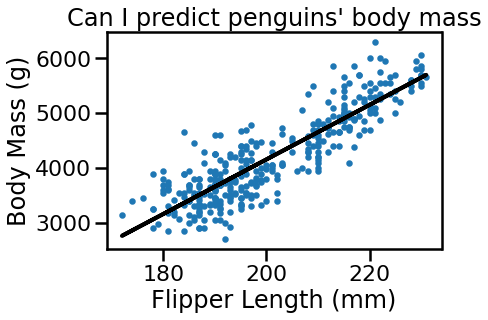

In [58]:
ax = data.plot.scatter(x=data.columns[0], y=data.columns[1])
ax.plot(X["Flipper Length (mm)"], y_pred, color="black", linewidth=4)
_ = ax.set_title("Can I predict penguins' body mass")

A scikit-learn predictive model will store the state of the model with attribute that finishes with an underscore. They are fitted attributes. For our linear model, they will be `coef_` and `intercept_`.

In [59]:
model.coef_, model.intercept_

(array([49.68556641]), -5780.831358077057)

## Properly evaluate a model via cross-validation

As previously stated, we can compute a metric to evaluate how good our trained model is.

In [60]:
from sklearn.metrics import r2_score

r2_score(y, model.predict(X))

0.7589925193571178

However, there is something wrong in what we just did. Indeed, if we would have a predictive model that would have memorize the training set, we would have obtain a perfect score. In practice, we don't use the same dataset to train and test a model to get a true estimate of the capability of a model to predict targets on new dataset. A metric computed on the training set is also called empirical error while the error computed on the testing set is called generalization error.

Thus, we could have first split our dataset into two sets: a training set to train our model and a testing set to check the statistical performance of our model.

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [62]:
model.fit(X_train, y_train)

LinearRegression()

In [63]:
model.coef_, model.intercept_

(array([49.31531566]), -5703.699111619706)

In [64]:
r2_score(y_train, model.predict(X_train))

0.7659339940796758

In [65]:
r2_score(y_test, model.predict(X_test))

0.7356183787802288

We observe that our model is not as precise on the testing set than on the training set. But this is not castastophic. We can show with another type of a model (decision tree) that the different can be quite drastic.

In [66]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [67]:
r2_score(y_train, model.predict(X_train))

0.8427390867299657

In [68]:
r2_score(y_test, model.predict(X_test))

0.6533411607974651

Let's come back to our linear model trained and tested on distinct sets. We observe a small difference between the training and testing scores. However, we are unable to know if the difference is significant, meaning that the difference might only be due to some random fluctuation given by our random initial data split. A proper evaluation should provide an estimate of the distribution of the different scores and not only a point-estimate. Cross-validation is a framework that would allow to take into account such variation.

The idea between cross-validation is to repeat the evaluation by varying the train and test set. This evaluation will therefore take into account the fluctuation that could happen in the "fit" process as well as in the "predict" process.

In [103]:
model = LinearRegression()

Scikit-learn provides the `sklearn.model_selection.cross_validate` function to repeat this train-test evaluation.

In [104]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
cv_results = cross_validate(
    model, X, y, cv=cv,
    scoring="r2",
    return_train_score=True,
)

In [105]:
cv_results = pd.DataFrame(cv_results)

In [106]:
cv_results[["train_score", "test_score"]]

,train_score,test_score
0,0.768495,0.710592
1,0.734377,0.836193
2,0.755871,0.756729
3,0.763002,0.736550
4,0.771886,0.685102


In [107]:
cv_results[["train_score", "test_score"]].mean()

train_score    0.758726
test_score     0.745033
dtype: float64

In [108]:
cv_results[["train_score", "test_score"]].std()

train_score    0.014899
test_score     0.057656
dtype: float64

We can observe that we have close result between the train and test score. However, the distribution of the test score is a bit larger. We could indeed use a repeated k-fold cross-validation to get more estimate and plot the distributions of the scores.

In [111]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_repeats=10, n_splits=3, random_state=0)
cv_results = cross_validate(
    model, X, y, cv=cv,
    scoring="r2",
    return_train_score=True
)
cv_results = pd.DataFrame(cv_results)

(0.0, 1.0)

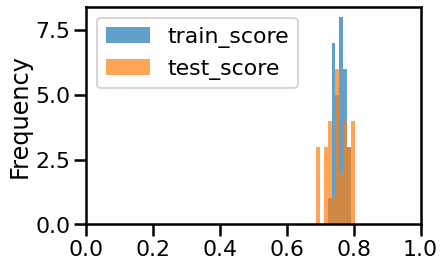

In [113]:
ax = cv_results[["train_score", "test_score"]].plot.hist(alpha=0.7)
ax.set_xlim([0, 1])

Visually, we can see that our model is behaving similarly on the training and testing sets with quite a small variation. This is quite a good new. Indeed, we can trust these results.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <p>Repeat the cross-validation using a <tt>KFold</tt> strategy. However, explicitely set the parameter <tt>shuffle=False</tt>. Explaih the differences that you observe compared to our previous analysis.</p>
</div>

In [133]:
cv = KFold(n_splits=5, shuffle=False)
cv_results = cross_validate(
    model, X, y, cv=cv,
    scoring="r2",
    return_train_score=True,
)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score,train_score
0,0.002597,0.001472,-0.139073,0.789425
1,0.002189,0.001785,0.240167,0.776089
2,0.001914,0.001406,0.670314,0.735878
3,0.001769,0.001150,0.528873,0.654802
4,0.001550,0.000932,-0.174130,0.778387


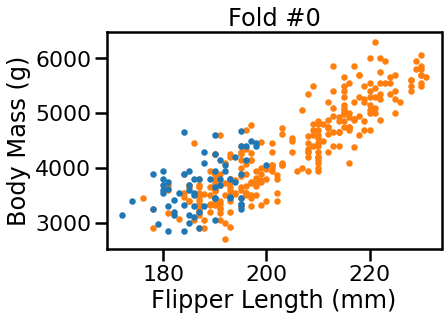

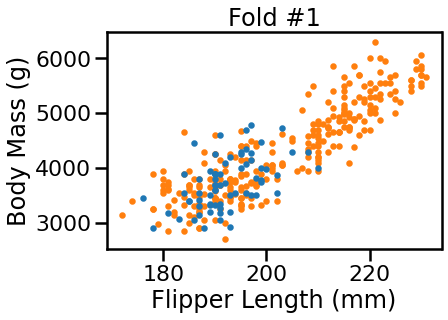

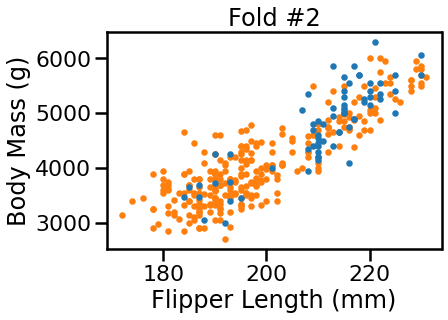

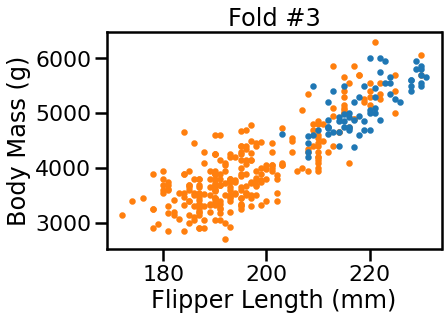

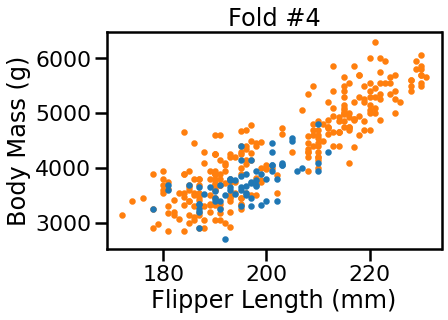

In [135]:
for cv_idx, (train, test) in enumerate(cv.split(X, y)):
    ax = data.iloc[train].plot.scatter(x=data.columns[0], y=data.columns[1], color="tab:orange")
    data.iloc[test].plot.scatter(x=data.columns[0], y=data.columns[1], ax=ax)
    ax.set_title(f"Fold #{cv_idx}")

## Use baseline during evaluation

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <p>You will use some baseline model to compare your previous linear model. For the cross-validation, get at least 30 estimates of the scores.</p>
    <ul>
        <li>Use a <tt>sklearn.dummy.DummyRegressor</tt> that will predict the mean target of the training set.</li>
        <li>Use the function <tt>sklearn.model_selection.permutation_test_score</tt> to get an estimate of the score of a completely random predictive model.</li>
        <li>Plot the distributions of the original linear model and the two above baseline. Plot only the test score distribution.</li>
    </ul>
</div>

In [146]:
cv = RepeatedKFold(n_repeats=10, n_splits=3, random_state=0)

In [147]:
cv_results = cross_validate(
    model, X, y, cv=cv,
    scoring="r2",
    return_train_score=True
)
cv_results = pd.DataFrame(cv_results)

In [148]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean")
cv_results_dummy = cross_validate(
    dummy_model, X, y, cv=cv,
    scoring="r2",
    return_train_score=True
)
cv_results_dummy = pd.DataFrame(cv_results_dummy)

In [149]:
from sklearn.model_selection import permutation_test_score

model = LinearRegression()
score, permutation_score, pvalue = permutation_test_score(
    model, X, y, cv=cv,
    n_jobs=-1, n_permutations=30
)
errors_permutation = pd.Series(permutation_score, name="Permuted error")

In [150]:
summary = pd.DataFrame()
summary["Tree test score"] = cv_results[["test_score"]]
summary["Dummy test score"] = cv_results_dummy[["test_score"]]
summary["Permuted error"] = errors_permutation

In [157]:
summary.head()

,Tree test score,Dummy test score,Permuted error
0,0.753684,-0.003098,-0.019925
1,0.778853,-0.034202,-0.013813
2,0.719732,-0.022315,-0.021029
3,0.801780,-0.000024,-0.018017
4,0.715127,-0.019601,-0.018541


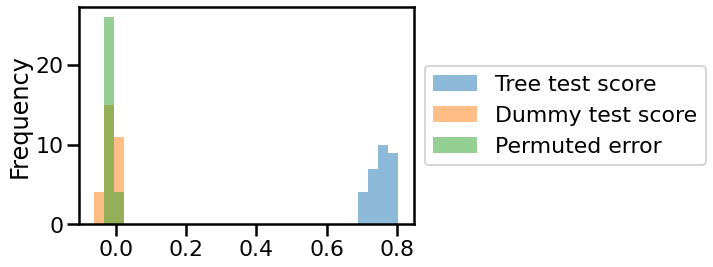

In [159]:
ax = summary.plot.hist(bins=30, alpha=0.5)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Evaluate the uncertainty of a model

As previously stated, cross-validation will evaluate the uncertainty of the full process fit/predict. Thus, it will involve that we are evaluated different models, one model on each different train set of the cross-validation.

If we have a single model, one can evaluate the uncertainty by bootstrapping the prediction of the model.

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <p>You will use some baseline model to compare your previous linear model. For the cross-validation, get at least 30 estimates of the scores.</p>
    <ul>
        <li>Compute the predictions of the model on the testing set.</li>
        <li>Create 100 bootstrap samples from the predictions (you can use <tt>np.random.choice</tt>).</li>
        <li>Plot the distribution of these bootstrap samples.</li>
    </ul>
</div>

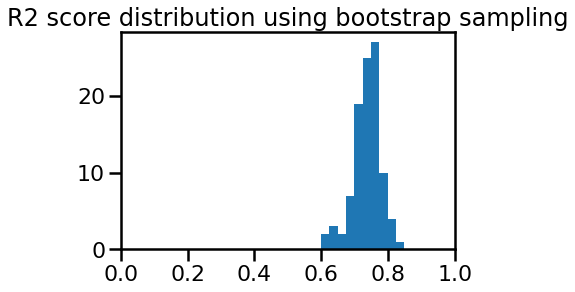

In [51]:
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)
y_pred = model.predict(X_test)

n_bootstrap = 100
bootstrap_score = []
for _ in range(n_bootstrap):
    bootstrap_indices = rng.choice(
        np.arange(y_pred.size), size=y_pred.size, replace=True
    )
    bootstrap_score.append(
        r2_score(y_test.to_numpy()[bootstrap_indices], y_pred[bootstrap_indices])
    )
plt.hist(bootstrap_score)
plt.xlim([0, 1])
_ = plt.title("R2 score distribution using bootstrap sampling")